### Import Libraries

In [51]:
import pandas as pd, numpy as np, torch, pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import gensim.parsing.preprocessing as gsp
from sklearn.metrics import recall_score
from scipy.stats import spearmanr

### Load Dataset

In [2]:
D_test = pd.read_csv('test_dataset.txt', sep='\t', header=0)
D_train = pd.read_csv('train_dataset.txt', sep='\t', header=0)
Users,Items = D_train['user_id'].unique(),D_train['item_id'].unique()
R = np.full((Users.shape[0], Items.shape[0]), 0.0)
for index, row in D_train.iterrows():
    R[np.where(Users == row['user_id']),np.where(Items == row['item_id'])]=row['rate']

### Learn U & I Matrices (As Ground Truth For Evaluation)

 99%|█████████▉| 99/100 [00:20<00:00,  4.72it/s]


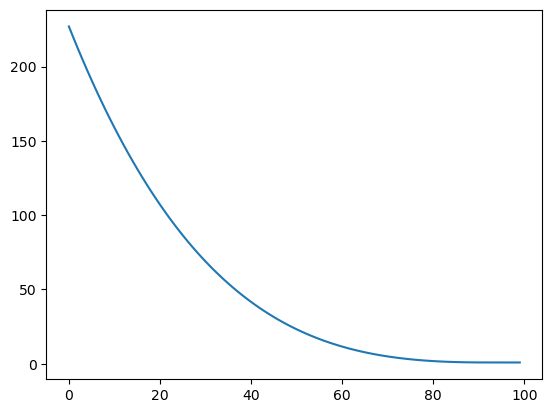

In [156]:
Latent_Dimension = 64
𝜆 = 1e-3
𝜏 = 1e-3
U = np.random.uniform(low=0, high=1, size=(Users.shape[0],Latent_Dimension))
I = np.random.uniform(low=0, high=1, size=(Items.shape[0],Latent_Dimension))
dU, dI = np.zeros_like(U), np.zeros_like(I)
N = D_train.shape[0]
def E(R,I,U): return np.sum(R*((R-U@I.T)**2))/N+𝜆*(np.linalg.norm(U)+np.linalg.norm(I))
def _dU(R,I,U): return np.sum(-2*(R-U@I.T)@I)/N+𝜆*2*U
def _dI(R,I,U): return np.sum(-2*(R-U@I.T).T@U)/N+𝜆*2*I
_Δ = []
for i in tqdm(range(100)):
    # calculate loss
    Δ = E(R,I,U)
    _Δ += [Δ.item()]
    # calculate gradient vectors
    dU = _dU(R,I,U)
    dI = _dI(R,I,U)
    # calculate descent direction
    dU = dU/np.linalg.norm(dU)
    dI = dI/np.linalg.norm(dI)
    # bisection to find step size
    while Δ<E(R,I,U-dU): dU=dU/2
    while Δ<E(R,I-dI,U): dI=dI/2
    # update factors
    U -= dU
    I -= dI
    # early stopping
    if (np.linalg.norm(dI)<𝜏)&(np.linalg.norm(dU)<𝜏): break
    
plt.plot(list(range(len(_Δ))), _Δ)
plt.show()

# real vs approximate utility matrix at (0,0)
R1 = U@I.T

### Making Representation Vectors

In [166]:
# clean the text
def clean_text(text):
    return gsp.remove_stopwords(gsp.strip_tags(gsp.strip_punctuation(gsp.strip_numeric(text))))
D_train['review_text'] = D_train['review_text'].astype('string')
D_train['review_text'] = D_train['review_text'].fillna('')
D_train['review_text'] = D_train['review_text'].apply(clean_text)
# tokenize and transform the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
reviews = [torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)])[:,:512] for sentence in list(D_train['review_text'])]
with torch.no_grad():
    results = []
    for review in tqdm(reviews):
        try: results += [model(review).last_hidden_state.mean(dim=1).squeeze()]
        except: print(f"[error] : {review}")
    reviews_vec = torch.stack(results)
# store the texts

with open ("bert_review_vectors.pth", "wb") as f:
    pickle.dump(reviews_vec, f)

Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 23038/23038 [1:54:29<00:00,  3.35it/s]  


### Part 3.A:: Replacing I Matrix

In [53]:
# load representation vectors
with open ("bert_review_vectors.pth", "rb") as f:
    reviews_vec = pickle.load(f).numpy()
# make 64 dimensional representation of comments
pca = PCA(n_components=64)
pca.fit(reviews_vec)
reviews_pca_vec = pca.transform(reviews_vec)
# make Item Comment matrix
Item_Comment = []
PCA_Item_Comment = []
for item in Items: PCA_Item_Comment += [np.mean(reviews_pca_vec[[(D_train.loc[D_train['item_id'] == item].index)[0].astype(int)],:], axis=0)]
for item in Items: Item_Comment += [np.mean(reviews_vec[[(D_train.loc[D_train['item_id'] == item].index)[0].astype(int)],:], axis=0)]
bert_I = np.array(Item_Comment)
pca_I = np.array(PCA_Item_Comment)
R2 = U@pca_I.T

### Part 3.B:: Concatinating I Matrix

In [54]:
concatinated_I = np.concatenate((I, bert_I), axis=-1)
pca = PCA(n_components=64)
pca.fit(concatinated_I)
pca_concatinated_I = pca.transform(concatinated_I)
R3 = U@pca_concatinated_I.T

### Evaluation

In [152]:
def Recall(y_true,y_pred,k): return np.intersect1d(y_true, y_pred).shape[0]/k
def DCG(X): return X/(np.log2(1+np.arange(X.shape[0]))+np.eye(1,X.shape[0]))
def NDCG(y_true,y_pred,k): return np.sum((DCG(y_pred)/DCG(y_true))[:k])
def Rank_Correlation(y_true,y_pred): return spearmanr(y_true, y_pred)
def evaluate(y_true, y_pred, label, y_true_matrix, y_pred_matrix):
    _R,_N,_C = [],[],[],
    for ind,y in enumerate(zip(y_true,y_pred)):
        y_t,y_p = y[0],y[1]
        _R += [Recall(y_t,y_p,20)]
        _N += [NDCG(y_true_matrix[ind,y_t],y_pred_matrix[ind,y_p],20)]
        _C += [Rank_Correlation(y_t,y_p)]
    _R = np.array(_R).mean()
    _N = np.array(_N).mean()
    _C = np.array(_C).mean()
    print(f"Evaluation Results Of {label}:")
    print(f"[Recall]          : {_R:0.2f}")
    print(f"[NDCG]            : {_N:0.2f}")
    print(f"[Rank_Correlation]: {_C:0.2f}")

In [153]:
I0,I1 = np.where(R > 0)
ground_truth, bert_method, concatinate_method = [],[],[]

for I,r1 in enumerate(np.argsort(-R1,axis=-1)):
    ground_truth += [r1[np.in1d(r1, I1[np.where(I0==I)], invert=True)][:20]]
for I,r2 in enumerate(np.argsort(-R2,axis=-1)):
    bert_method += [r2[np.in1d(r2, I1[np.where(I0==I)], invert=True)][:20]]
for I,r3 in enumerate(np.argsort(-R3,axis=-1)):
    concatinate_method += [r3[np.in1d(r3, I1[np.where(I0==I)], invert=True)][:20]]

ground_truth = np.array(ground_truth)
bert_method = np.array(bert_method)
concatinate_method = np.array(concatinate_method)

### BERT Method Result

In [154]:
evaluate(ground_truth,bert_method,"Pure BERT Representation", R1, R2)

Evaluation Results Of Pure BERT Representation:
[Recall]          : 0.03
[NDCG]            : 23.00
[Rank_Correlation]: 0.25


In [155]:
evaluate(ground_truth,concatinate_method,"Concatinated Representation", R1, R3)

Evaluation Results Of Concatinated Representation:
[Recall]          : 0.03
[NDCG]            : 23.57
[Rank_Correlation]: 0.26
